In [2]:
!pip install pandas numpy nltk spacy tqdm

## Importing the Dependencies

In [3]:
import pandas as pd

df = pd.read_csv("headlines.csv")

print(df.info())
print(df.head())

print("Missing values:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178737 entries, 0 to 178736
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             178737 non-null  int64  
 1   Unnamed: 0        178737 non-null  int64  
 2   url               178737 non-null  object 
 3   headline_no_site  178736 non-null  object 
 4   site              178736 non-null  object 
 5   time              178736 non-null  object 
 6   country           178736 non-null  object 
 7   bias              178736 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 10.9+ MB
None
   index  Unnamed: 0                                                url  \
0      0           0  https://www.iol.co.za/entertainment/movies-the...   
1      1           1  https://www.iol.co.za/entertainment/music/the-...   
2      2           2  https://www.iol.co.za/entertainment/celebrity-...   
3      3           3  https://www.iol.co.z

# Analysing and Preprocessing the dataset

Dropping null and duplicate values

In [4]:
df.dropna(inplace=True)

df.drop_duplicates(inplace=True)

In [20]:
df.shape

(178736, 16)

In [6]:
df.head()

,index,Unnamed: 0,url,headline_no_site,site,time,country,bias
0,0,0,https://www.iol.co.za/entertainment/movies-the...,'Lady Bird' buzzes through young sexuality,iol.co.za,2018-02-23 08:00:00+00:00,South Africa,0.000000
1,1,1,https://www.iol.co.za/entertainment/music/the-...,The shadowy urban POP super Starrah who loves ...,iol.co.za,2018-01-10 08:00:00+00:00,South Africa,0.166667
2,2,2,https://www.iol.co.za/entertainment/celebrity-...,Rihanna pens heartfelt tribute to her mom in b...,iol.co.za,2018-02-21 08:00:00+00:00,South Africa,0.333333
3,3,3,https://www.iol.co.za/news/south-africa/wester...,Shock as woman accused of killing teen girlfri...,iol.co.za,2018-02-27 08:00:00+00:00,South Africa,0.333333
4,4,4,https://www.iol.co.za/business-report/careers/...,TOP STORY: Meet South Africa's new first lady ...,iol.co.za,2018-02-15 08:00:00+00:00,South Africa,0.166667


In [21]:
df.describe()

,index,Unnamed: 0,bias,female_bias_words,female_words,crime and violence,empowerement,people_and_places,race_ethnicity_and_identity,total_bias_score
count,178736.000000,178736.000000,178736.000000,178736.000000,178736.000000,178736.000000,178736.000000,178736.000000,178736.000000,178736.000000
mean,89367.500000,89367.500000,0.174890,0.228409,1.055288,0.357382,0.211955,0.362518,0.062550,2.278103
std,51596.783194,51596.783194,0.102216,0.487515,0.641623,0.678482,0.482486,0.645136,0.261697,1.321977
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44683.750000,44683.750000,0.166667,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,89367.500000,89367.500000,0.166667,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,134051.250000,134051.250000,0.166667,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000
max,178735.000000,178735.000000,0.833333,5.000000,6.000000,6.000000,5.000000,6.000000,4.000000,10.000000


## Lemmetization and Tokenisation of text

In [8]:
import spacy
import string
from nltk.corpus import stopwords
import nltk

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and token.is_alpha]
    return " ".join(tokens)


df["cleaned_headline"] = df["headline_no_site"].apply(clean_text)


print(df[["headline_no_site", "cleaned_headline"]].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                    headline_no_site  \
0         'Lady Bird' buzzes through young sexuality   
1  The shadowy urban POP super Starrah who loves ...   
2  Rihanna pens heartfelt tribute to her mom in b...   
3  Shock as woman accused of killing teen girlfri...   
4  TOP STORY: Meet South Africa's new first lady ...   

                                    cleaned_headline  
0                     lady bird buzz young sexuality  
1       shadowy urban pop super starrah love privacy  
2    rihanna pen heartfelt tribute mom birthday post  
3  shock woman accuse kill teen girlfriend laugh ...  
4  top story meet south africas new first lady ts...  


## Analysing the bias words

In [9]:
import pandas as pd
import json

with open("word_dictionaries.json", "r") as f:
    word_dict = json.load(f)

print("Categories:", word_dict.keys())


Categories: dict_keys(['female_bias_words', 'female_words', 'crime and violence', 'empowerement', 'people_and_places', 'race_ethnicity_and_identity'])


In [11]:
def count_bias_words(text, word_list):
    words = text.lower().split()
    return sum(1 for word in words if word in word_list)

bias_categories = ["female_bias_words", "female_words", "crime and violence",
                   "empowerement", "people_and_places", "race_ethnicity_and_identity"]

for category in bias_categories:
    df[category] = df["headline_no_site"].apply(lambda x: count_bias_words(str(x), word_dict.get(category, [])))

print(df.head())


   index  Unnamed: 0                                                url  \
0      0           0  https://www.iol.co.za/entertainment/movies-the...   
1      1           1  https://www.iol.co.za/entertainment/music/the-...   
2      2           2  https://www.iol.co.za/entertainment/celebrity-...   
3      3           3  https://www.iol.co.za/news/south-africa/wester...   
4      4           4  https://www.iol.co.za/business-report/careers/...   

                                    headline_no_site       site  \
0         'Lady Bird' buzzes through young sexuality  iol.co.za   
1  The shadowy urban POP super Starrah who loves ...  iol.co.za   
2  Rihanna pens heartfelt tribute to her mom in b...  iol.co.za   
3  Shock as woman accused of killing teen girlfri...  iol.co.za   
4  TOP STORY: Meet South Africa's new first lady ...  iol.co.za   

                        time       country      bias  \
0  2018-02-23 08:00:00+00:00  South Africa  0.000000   
1  2018-01-10 08:00:00+00:00  Sout

In [13]:
df["total_bias_score"] = df[bias_categories].sum(axis=1)

print(df[["headline_no_site", "total_bias_score"]].head())


                                    headline_no_site  total_bias_score
0         'Lady Bird' buzzes through young sexuality                 0
1  The shadowy urban POP super Starrah who loves ...                 1
2  Rihanna pens heartfelt tribute to her mom in b...                 3
3  Shock as woman accused of killing teen girlfri...                 4
4  TOP STORY: Meet South Africa's new first lady ...                 3


In [14]:
df.to_csv("processed_headlines_with_bias.csv", index=False)
print("Processed dataset saved successfully!")


Processed dataset saved successfully!


In [15]:
!pip install matplotlib seaborn wordcloud nltk

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

df = pd.read_csv("processed_headlines_with_bias.csv")

print(df.head())


   index  Unnamed: 0                                                url  \
0      0           0  https://www.iol.co.za/entertainment/movies-the...   
1      1           1  https://www.iol.co.za/entertainment/music/the-...   
2      2           2  https://www.iol.co.za/entertainment/celebrity-...   
3      3           3  https://www.iol.co.za/news/south-africa/wester...   
4      4           4  https://www.iol.co.za/business-report/careers/...   

                                    headline_no_site       site  \
0         'Lady Bird' buzzes through young sexuality  iol.co.za   
1  The shadowy urban POP super Starrah who loves ...  iol.co.za   
2  Rihanna pens heartfelt tribute to her mom in b...  iol.co.za   
3  Shock as woman accused of killing teen girlfri...  iol.co.za   
4  TOP STORY: Meet South Africa's new first lady ...  iol.co.za   

                        time       country      bias  \
0  2018-02-23 08:00:00+00:00  South Africa  0.000000   
1  2018-01-10 08:00:00+00:00  Sout

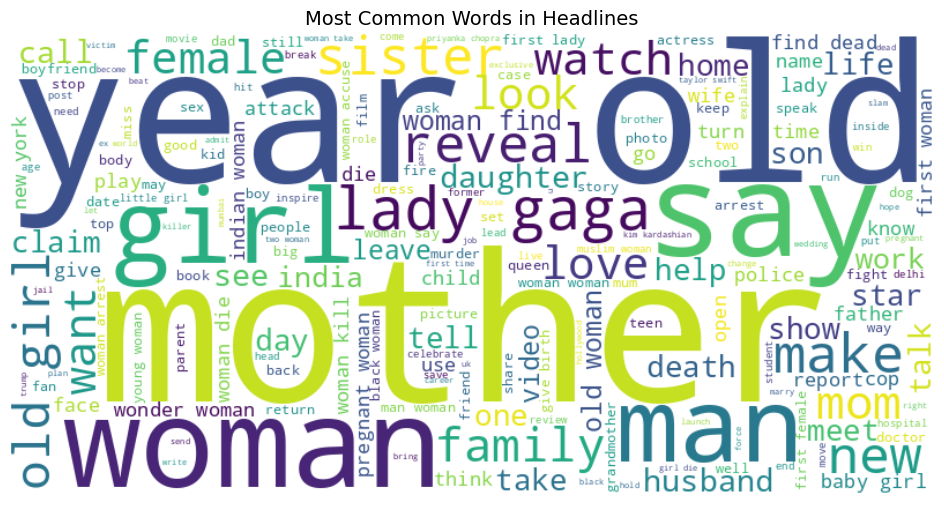

In [17]:
text = " ".join(df["cleaned_headline"].dropna())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Headlines", fontsize=14)
plt.show()

Consolidating the female biased words in the headlines

<ipython-input-18-05293fc4e6bd>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_bias_counts.index, y=gender_bias_counts.values, palette=["#FF69B4", "#1E90FF"])


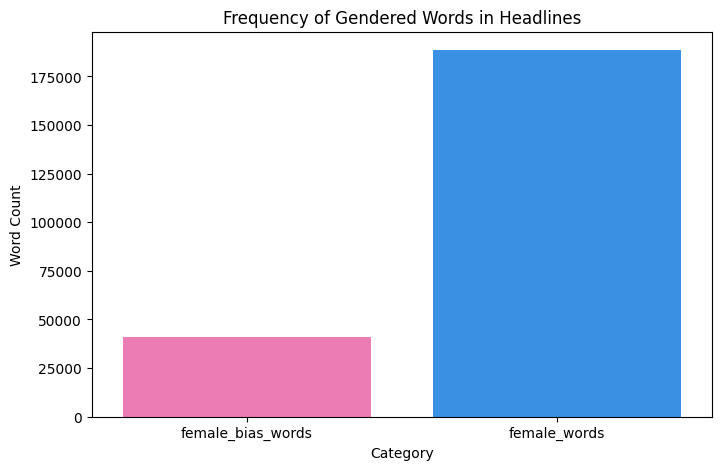

In [18]:
gender_bias_counts = df[["female_bias_words", "female_words"]].sum()

plt.figure(figsize=(8, 5))
sns.barplot(x=gender_bias_counts.index, y=gender_bias_counts.values, palette=["#FF69B4", "#1E90FF"])
plt.title("Frequency of Gendered Words in Headlines")
plt.xlabel("Category")
plt.ylabel("Word Count")
plt.show()

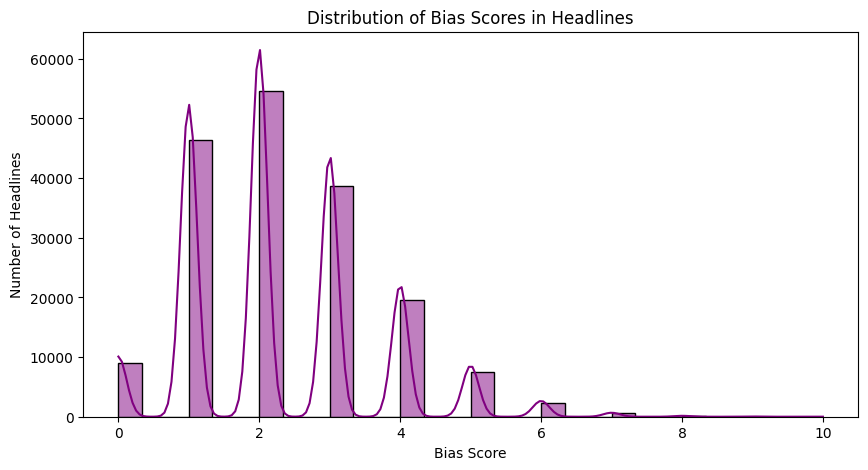

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(df["total_bias_score"], bins=30, kde=True, color="purple")
plt.title("Distribution of Bias Scores in Headlines")
plt.xlabel("Bias Score")
plt.ylabel("Number of Headlines")
plt.show()

### Extracting Dependency Relations

Analysing the gender adjectives

In [26]:
import spacy

def extract_dependency_relations(text):
    if not isinstance(text, str):
        return []
    doc = nlp(text)
    relations = [(token.head.text, token.text, token.dep_) for token in doc if token.dep_ in ("amod", "nsubj", "dobj")]
    return relations

df["dependency_relations"] = df["cleaned_headline"].apply(extract_dependency_relations)
print(df[["cleaned_headline", "dependency_relations"]].head())


                                    cleaned_headline  \
0                     lady bird buzz young sexuality   
1       shadowy urban pop super starrah love privacy   
2    rihanna pen heartfelt tribute mom birthday post   
3  shock woman accuse kill teen girlfriend laugh ...   
4  top story meet south africas new first lady ts...   

                                dependency_relations  
0                         [(sexuality, young, amod)]  
1     [(privacy, shadowy, amod), (pop, urban, amod)]  
2         [(pen, rihanna, nsubj), (pen, post, dobj)]  
3  [(accuse, woman, nsubj), (kill, accuse, nsubj)...  
4  [(story, top, amod), (meet, story, nsubj), (ts...  


In [28]:
from textblob import TextBlob

def get_sentiment(text):
    if not isinstance(text, str):
        return 0
    return TextBlob(text).sentiment.polarity

df["cleaned_headline"] = df["cleaned_headline"].fillna("")

df["sentiment_score"] = df["cleaned_headline"].apply(get_sentiment)

print(df[["cleaned_headline", "sentiment_score"]].head())


                                    cleaned_headline  sentiment_score
0                     lady bird buzz young sexuality         0.100000
1       shadowy urban pop super starrah love privacy         0.277778
2    rihanna pen heartfelt tribute mom birthday post         0.000000
3  shock woman accuse kill teen girlfriend laugh ...         0.150000
4  top story meet south africas new first lady ts...         0.295455


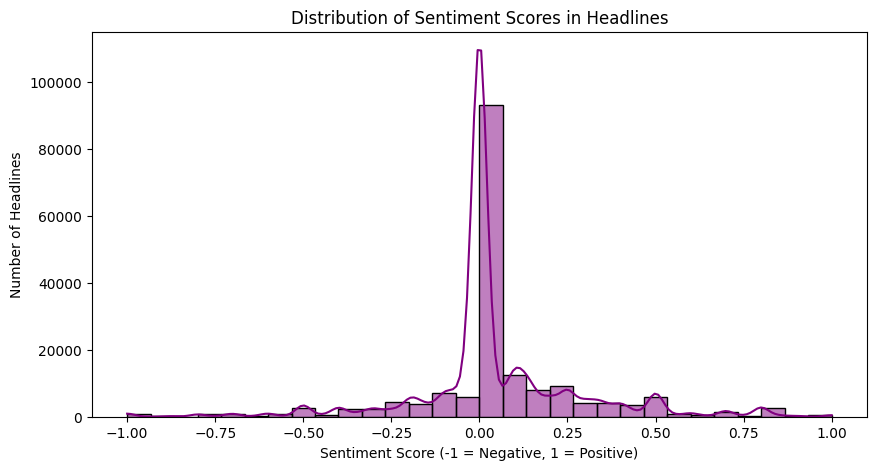

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df["sentiment_score"], bins=30, kde=True, color="purple")
plt.title("Distribution of Sentiment Scores in Headlines")
plt.xlabel("Sentiment Score (-1 = Negative, 1 = Positive)")
plt.ylabel("Number of Headlines")
plt.show()

# Model Training

In [31]:
import pandas as pd
from transformers import RobertaTokenizer


df = pd.read_csv("processed_headlines_with_bias.csv")

df["label"] = (df["total_bias_score"] > 0).astype(int)

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["cleaned_headline"], padding="max_length", truncation=True)

df = df.dropna(subset=["cleaned_headline"])
df["tokens"] = df["cleaned_headline"].apply(lambda x: tokenizer(x, padding="max_length", truncation=True, return_tensors="pt"))

print("Tokenization Complete!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Tokenization Complete!


In [32]:
import torch
from torch.utils.data import Dataset

class BiasDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

encodings = tokenizer(df["cleaned_headline"].tolist(), padding=True, truncation=True, return_tensors="pt")
labels = df["label"].tolist()
dataset = BiasDataset(encodings, labels)

In [34]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["cleaned_headline"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

train_encodings = tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt")
val_encodings = tokenizer(val_texts, padding=True, truncation=True, return_tensors="pt")


train_dataset = BiasDataset(train_encodings, train_labels)
val_dataset = BiasDataset(val_encodings, val_labels)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

test_texts = df["cleaned_headline"].tolist()
test_encodings = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt")

with torch.no_grad():
    outputs = model(**test_encodings)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Print Accuracy & Report
accuracy = accuracy_score(df["label"], predictions.numpy())
print(f"Model Accuracy: {accuracy:.2f}")
print(classification_report(df["label"], predictions.numpy()))

In [ ]:
model.save_pretrained("roberta_bias_detector")
tokenizer.save_pretrained("roberta_bias_detector")

# Naive Bayes ALgorithm

In [37]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

df = pd.read_csv("processed_headlines_with_bias.csv")

df["label"] = (df["total_bias_score"] > 0).astype(int)

df = df.dropna(subset=["cleaned_headline", "label"])

vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X = vectorizer.fit_transform(df["cleaned_headline"])
y = df["label"].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("TF-IDF Transformation Complete!")


TF-IDF Transformation Complete!


In [38]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.94      0.01      0.02      1774
           1       0.95      1.00      0.97     33973

    accuracy                           0.95     35747
   macro avg       0.94      0.50      0.50     35747
weighted avg       0.95      0.95      0.93     35747



In [39]:
import joblib

joblib.dump(model, "naive_bayes_bias_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']